Variations of object localization using VGG16, data augmentation with ImageDataGenerator and three cute Pokemons

- detect white rectangle on black background
- detect object on black background in changing size and orientation
- as above but on various noisy background
- detect multiclass object and consider object missing

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from imageio import imread
from skimage.transform import resize
from glob import glob

# White box localization

Detect white rectangle on the black backgroud and draw a bounding box around it

## Helper functions

In [ ]:
def image_generator(batch_size=64):
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, 100, 100, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):   # initializing a batch of images (white rectangles on black background)
        row0 = np.random.randint(90)    # coordinates for the image
        col0 = np.random.randint(90)
        row1 = np.random.randint(row0, 100)
        col1 = np.random.randint(col0, 100)

        X[i, row0:row1, col0:col1, :] = 1
        Y[i,0] = row0/100.
        Y[i,1] = col0/100.
        Y[i,2] = (row1 - row0)/100.
        Y[i,3] = (col1 - col0)/100.

      yield X, Y

In [ ]:
# generate a random image, predict the white rectangle coordinates and draw them
def make_predictions():
  x = np.zeros((100, 100, 3))
  row0 = np.random.randint(90)
  col0 = np.random.randint(90)
  row1 = np.random.randint(row0, 100)
  col1 = np.random.randint(col0, 100)
  x[row0:row1, col0:col1, :] = 1
  print(row0, col0, row1, col1)

  X = np.expand_dims(x, 0)  # to dimension (1, 100, 100, 3)
  p = model.predict(X)[0]

  fig, ax = plt.subplots(1)
  ax.imshow(x)
  rect = Rectangle(
      (p[1] * 100, p[0]*100),
      p[3]*100, p[2]*100, linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

## Transfer learning

In [ ]:
# input_shape is RGB bc we take weights from ImageNet training which contained RGB images
# even though we detect on black&white image
# not including top (aka headless network) bc we add own classification layer
vgg = VGG16(input_shape=[100,100,3], include_top=False, weights='imagenet')

# adding classification layer with 4 classes
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

In [ ]:
model.fit_generator(image_generator(), steps_per_epoch=50, epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


50/50 [==============================] - 24s 185ms/step - loss: 0.5895
Epoch 2/5
50/50 [==============================] - 9s 186ms/step - loss: 0.5109
Epoch 3/5
50/50 [==============================] - 9s 189ms/step - loss: 0.5075
Epoch 4/5
50/50 [==============================] - 10s 191ms/step - loss: 0.5033
Epoch 5/5
50/50 [==============================] - 10s 193ms/step - loss: 0.5059


68 39 98 75


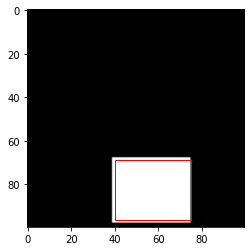

In [ ]:
make_predictions()

# Pokemon localization

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2022-07-20 16:17:16--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2022-07-20 16:17:17 (67.3 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [ ]:
! ls

charmander-tight.png  sample_data


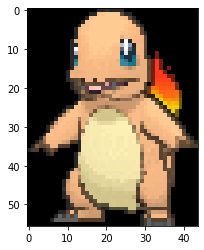

(56, 44, 3)


In [ ]:
ch = image.load_img('charmander-tight.png') # tightest box that could fit the image, the background is black bc it's pillow object
plt.imshow(ch)
plt.show()
print(np.array(ch).shape)

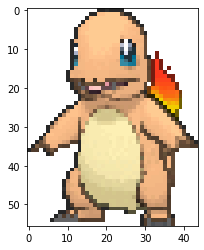

(56, 44, 4)


In [ ]:
ch = imread('charmander-tight.png') # white background bc array object, shape is 4-channel bc alpha/transparency included
plt.imshow(ch)
plt.show()
print(np.array(ch).shape)
# in the alpha channel pixels are 0 on background and 255 on pokemon

In [ ]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, CH_C = ch.shape

## Helper functions

In [ ]:
def pokemon_generator(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # pokemon location on the image
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_H)
        row1 = row0 + CH_H  # size of the pokemon is fixed
        col1 = col0 + CH_W
        X[i, row0:row1, col0:col1, :] = ch[:,:,:3]

        Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
        Y[i,1] = col0/POKE_DIM
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [ ]:
def make_model():
  vgg = VGG16(
      input_shape = [POKE_DIM, POKE_DIM, 3],
      include_top = False,
      weights = 'imagenet'
  )

  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
  model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.001))
  return model

In [ ]:
# generate random image with pokemon, detect it, localize and draw a bounding box around
def pokemon_predictions():
  # generate random image coordinates
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  x[row0:row1, col0:col1, :] = ch[:,:,:3]   # we assign pokemon to generated square of black background
  print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # bounding box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)

  print("pred: ", row0, col0, row1, col1)
  print("loss: ", -np.mean(y * np.log(p) + (1-y) * np.log(1-p)))    # loss with binary crossentropy

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

training and predicting

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


50/50 [==============================] - 46s 718ms/step - loss: 0.6153
Epoch 2/5
50/50 [==============================] - 35s 704ms/step - loss: 0.5550
Epoch 3/5
50/50 [==============================] - 35s 707ms/step - loss: 0.5523
Epoch 4/5
50/50 [==============================] - 35s 707ms/step - loss: 0.5523
Epoch 5/5
50/50 [==============================] - 35s 704ms/step - loss: 0.5536


true 10 110 66 154
pred:  11 109 67 153
loss:  0.5017118038795888


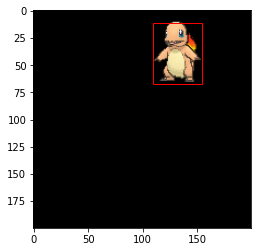

In [ ]:
pokemon_predictions()

# Resized pokemon localization

scale factor needs to be included in data generator

In [ ]:
def pokemon_generator_with_resize(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # resizing image
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True
        ).astype(np.uint8)
        
        # pokemon location on the image
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_H)
        row1 = row0 + new_height
        col1 = col0 + new_width
        X[i, row0:row1, col0:col1, :] = ch[:,:,:3]

        Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
        Y[i,1] = col0/POKE_DIM
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [ ]:
def make_model_for_resized():
  vgg = VGG16(
      input_shape = [POKE_DIM, POKE_DIM, 3],
      include_top = False,
      weights = 'imagenet'
  )

  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
  model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.0001))
  return model

In [ ]:
def pokemon_predictions_for_resized():
  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True
  ).astype(np.uint8)

  # generate random image coordinates
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W
  x[row0:row1, col0:col1, :] = ch[:,:,:3]   # we assign pokemon to generated square of black background
  print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # bounding box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)

  print("pred: ", row0, col0, row1, col1)
  print("loss: ", -np.mean(y * np.log(p) + (1-y) * np.log(1-p)))    # loss with binary crossentropy

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

In [ ]:
model = make_model_for_resized()
model.fit_generator(
    pokemon_generator_with_resize(),
    steps_per_epoch=50,
    epochs=5
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
50/50 [==============================] - 38s 743ms/step - loss: 0.5612
Epoch 2/5
50/50 [==============================] - 37s 734ms/step - loss: 0.5543
Epoch 3/5
50/50 [==============================] - 37s 733ms/step - loss: 0.5537
Epoch 4/5
50/50 [==============================] - 37s 738ms/step - loss: 0.5536
Epoch 5/5
50/50 [==============================] - 37s 733ms/step - loss: 0.5535


true 70 43 126 87
pred:  71 42 128 85
loss:  0.5720342070423066


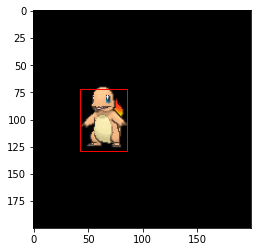

In [ ]:
pokemon_predictions_for_resized()

# Flipped pokemon localization

In [ ]:
def pokemon_generator_flip(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # pokemon location on the image
        row0 = np.random.randint(POKE_DIM - CH_H)
        col0 = np.random.randint(POKE_DIM - CH_H)
        row1 = row0 + CH_H  # size of the pokemon is fixed
        col1 = col0 + CH_W

        if np.random.random() < 0.5:
          obj = np.fliplr(ch)
        else:
          obj = ch

        X[i, row0:row1, col0:col1, :] = ch[:,:,:3]

        Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
        Y[i,1] = col0/POKE_DIM
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

In [ ]:
def pokemon_predictions_for_flip():
  # generate random image coordinates
  x = np.zeros((POKE_DIM, POKE_DIM, 3))
  row0 = np.random.randint(POKE_DIM - CH_H)
  col0 = np.random.randint(POKE_DIM - CH_W)
  row1 = row0 + CH_H
  col1 = col0 + CH_W

  r = np.random.random()
  print(r)
  if r < 0.5:
    obj = np.fliplr(ch)
    print("Flip!")
  else:
    obj = ch

  x[row0:row1, col0:col1, :] = obj[:,:,:3]   # we assign pokemon to generated square of black background
  print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # bounding box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)

  print("pred: ", row0, col0, row1, col1)
  print("loss: ", -np.mean(y * np.log(p) + (1-y) * np.log(1-p)))    # loss with binary crossentropy

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator_flip(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


50/50 [==============================] - 36s 712ms/step - loss: 0.6358
Epoch 2/5
50/50 [==============================] - 35s 704ms/step - loss: 0.5569
Epoch 3/5
50/50 [==============================] - 35s 702ms/step - loss: 0.5550
Epoch 4/5
50/50 [==============================] - 35s 705ms/step - loss: 0.5549
Epoch 5/5
50/50 [==============================] - 35s 703ms/step - loss: 0.5535


0.24973472934745278
Flip!
true 142 113 198 157
pred:  142 109 198 152
loss:  0.6018694967776537


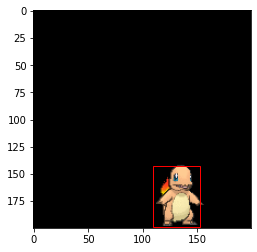

In [ ]:
pokemon_predictions_for_flip()

# Pokemon localization on fancy background

to paste pokemon on fancy background we need to cut out its shape from background (make a mask) and add it in again. simple pasting/adding won't wokr bc pokemon has this black background around but we only want the orange parts to appear on generated image

use alpha/transparency channel: 
mask = (obj[:,:,:3] == 0) -> where the black bg around pokemon should be

mask == 1 -> where the pokemon should be

-> slice the pokemon img with the mask and call it a day

## Load the data

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2022-07-19 19:21:36--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  1.32MB/s    in 0.4s    

2022-07-19 19:21:37 (1.32 MB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [ ]:
! unzip -n backgrounds.zip 

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

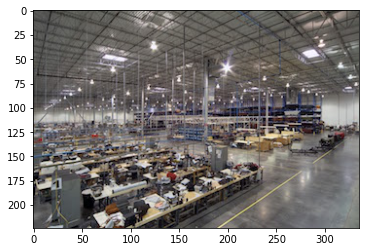

In [ ]:
backgrounds = []

background_files = glob('backgrounds/*jpg')
for f in background_files:
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

plt.imshow(backgrounds[np.random.randint(len(backgrounds))])

## Helper functions

In [ ]:
def pokemon_generator_bg(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # randomly choose the background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()  # background for pokemon

        # resizing image
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width = int(CH_W * scale)
        obj = resize(
            ch,
            (new_height, new_width),
            preserve_range=True
        ).astype(np.uint8)
        
        # flip perhaps
        if np.random.random() < 0.5:
          obj = np.fliplr(obj)

        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # placing pokemon into the background
        mask = (obj[:,:,3] == 0) # find where pokemon is 0 (black)
        bg_slice = X[i, row0:row1, col0:col1, :] # slice to place obj
        bg_slice = np.expand_dims(mask, -1) * bg_slice # results in all black in the place of mask, expand_dims bc its 2D before and bg_slice is shape (h,w,3)
        bg_slice += obj[:,:,:3] # add pokemon to the slice, instead of assigning
        X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

        Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
        Y[i,1] = col0/POKE_DIM
        Y[i,2] = (row1 - row0)/POKE_DIM
        Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

## Actual fitting

In [ ]:
xx = None
yy = None

for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

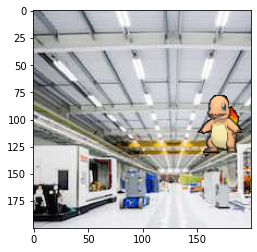

In [ ]:
plt.imshow(xx[np.random.randint(49)])

In [ ]:
model = make_model_for_resized()
model.fit_generator(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
50/50 [==============================] - 40s 786ms/step - loss: 0.5625
Epoch 2/5
50/50 [==============================] - 39s 772ms/step - loss: 0.5429
Epoch 3/5
50/50 [==============================] - 39s 775ms/step - loss: 0.5442
Epoch 4/5
50/50 [==============================] - 39s 776ms/step - loss: 0.5424
Epoch 5/5
50/50 [==============================] - 39s 772ms/step - loss: 0.5454


In [ ]:
def pokemon_predictions_bg():

  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()

  scale = 0.5 + np.random.random()
  new_height = int(CH_H * scale)
  new_width = int(CH_W * scale)
  obj = resize(
      ch,
      (new_height, new_width),
      preserve_range=True
  ).astype(np.uint8)

  if np.random.random() < 0.5:
    obj = np.fliplr(obj)

  # generate random image coordinates
  row0 = np.random.randint(POKE_DIM - new_height)
  col0 = np.random.randint(POKE_DIM - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width

  # placing pokemon into the background
  mask = (obj[:,:,3] == 0) 
  bg_slice = x[row0:row1, col0:col1, :] 
  bg_slice = np.expand_dims(mask, -1) * bg_slice 
  bg_slice += obj[:,:,:3] 
  x[row0:row1, col0:col1, :] = bg_slice 
  print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  y = np.zeros(4)
  y[0] = row0/POKE_DIM
  y[1] = col0/POKE_DIM
  y[2] = (row1 - row0)/POKE_DIM
  y[3] = (col1 - col0)/POKE_DIM

  # bounding box
  row0 = int(p[0]*POKE_DIM)
  col0 = int(p[1]*POKE_DIM)
  row1 = int(row0 + p[2]*POKE_DIM)
  col1 = int(col0 + p[3]*POKE_DIM)

  print("pred: ", row0, col0, row1, col1)
  print("loss: ", -np.mean(y * np.log(p) + (1-y) * np.log(1-p)))    # loss with binary crossentropy

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

true 4 115 52 153
pred:  3 115 48 150
loss:  0.45468436579219995


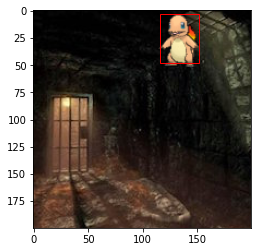

In [ ]:
pokemon_predictions_bg()

# Localization if might not appear

In [ ]:
def custom_loss(y_true, y_pred):
  bce = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1]) # loss on (row, col, height, width)
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])  # loss on (ifObjectAppears)
  return 3 * bce * y_true[:, -1] + 0.5 * bce2 # weighted sum of both losses

In [ ]:
def make_model():
  vgg = VGG16(
      input_shape = [POKE_DIM, POKE_DIM, 3],
      include_top = False,
      weights = 'imagenet'
  )

  x = Flatten()(vgg.output)
  x = Dense(5, activation='sigmoid')(x) # predict 4 coordinates and 5th - if object appears
  model = Model(vgg.input, x)
  model.compile(loss = custom_loss, optimizer=Adam(learning_rate=0.0001))
  return model

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2022-07-20 16:23:02--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  1.72MB/s    in 0.3s    

2022-07-20 16:23:03 (1.72 MB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [ ]:
! unzip -n backgrounds.zip 

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

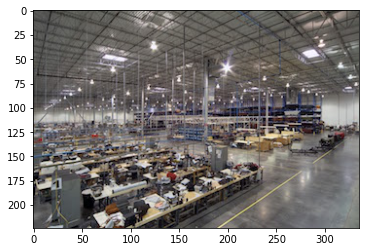

In [ ]:
backgrounds = []

background_files = glob('backgrounds/*jpg')
for f in background_files:
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

plt.imshow(backgrounds[np.random.randint(len(backgrounds))])

In [ ]:
def pokemon_generator_bg(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 5))

      for i in range(batch_size):
        # randomly choose the background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()  # background for pokemon

        appear = (np.random.random() < 0.5)
        
        if appear:
          # resizing image
          scale = 0.5 + np.random.random()
          new_height = int(CH_H * scale)
          new_width = int(CH_W * scale)
          obj = resize(
              ch,
              (new_height, new_width),
              preserve_range=True
          ).astype(np.uint8)
          
          # flip perhaps
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # placing pokemon into the background
          mask = (obj[:,:,3] == 0) # find where pokemon is 0 (black)
          bg_slice = X[i, row0:row1, col0:col1, :] # slice to place obj
          bg_slice = np.expand_dims(mask, -1) * bg_slice # results in all black in the place of mask, expand_dims bc its 2D before and bg_slice is shape (h,w,3)
          bg_slice += obj[:,:,:3] # add pokemon to the slice, instead of assigning
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

      yield X / 255., Y

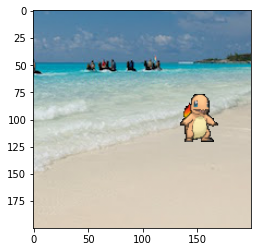

In [ ]:
xx = None
yy = None

for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

plt.imshow(xx[np.random.randint(49)])   # sanity check

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5
)

In [ ]:
def pokemon_predictions_bg():

  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()

  appear = (np.random.random() < 0.5)

  if appear:
    scale = 0.5 + np.random.random()
    new_height = int(CH_H * scale)
    new_width = int(CH_W * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True
    ).astype(np.uint8)

    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # generate random image coordinates
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # placing pokemon into the background
    mask = (obj[:,:,3] == 0) 
    bg_slice = x[row0:row1, col0:col1, :] 
    bg_slice = np.expand_dims(mask, -1) * bg_slice 
    bg_slice += obj[:,:,:3] 
    x[row0:row1, col0:col1, :] = bg_slice 
    print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  if p[4] > 0.5:
    # bounding box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred: ", row0, col0, row1, col1)
    rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
  else:
    print("pred: no pokemon :(")
    print("p = ", p[4])

  plt.show()

true 73 24 123 63
pred: no pokemon :(
p =  5.51491e-07


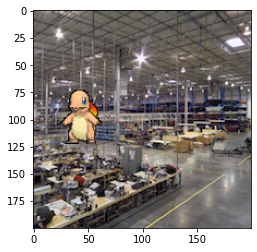

In [ ]:
pokemon_predictions_bg()

# Detect multiple classes

give VGG 2 outputs:

1. Dense layer for coordinates and appearance prediction (sigmoid)
2. Dense layer for class prediction (softmax)

and concatenate them

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png

File ‘charmander-tight.png’ already there; not retrieving.

File ‘backgrounds.zip’ already there; not retrieving.

--2022-07-20 16:58:34--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   3.35K  --.-KB/s    in 0s      

2022-07-20 16:58:34 (44.0 MB/s) - ‘bulbasaur-tight.png’ saved [3435/3435]

--2022-07-20 16:58:35--  https://lazyprogrammer.me/course_files/squirtle-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [ ]:
! ls

backgrounds	 bulbasaur-tight.png   __MACOSX     squirtle-tight.png
backgrounds.zip  charmander-tight.png  sample_data


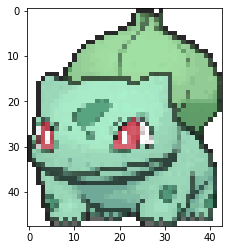

In [ ]:
ch = imread('charmander-tight.png')
bb = imread('bulbasaur-tight.png')
sq = imread('squirtle-tight.png')
plt.imshow(bb)
plt.show()

In [ ]:
POKE_DIM = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

poke_data = [
             [ch, CH_H, CH_W, CH_C],
             [bb, BB_H, BB_W, BB_C],
             [sq, SQ_H, SQ_W, SQ_C]
]

class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [ ]:
def custom_loss_multiclass(y_true, y_pred):
  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4])
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7])
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [ ]:
def make_model_multiclass():
  vgg = VGG16(
      input_shape = [POKE_DIM, POKE_DIM, 3],
      include_top = False,
      weights = 'imagenet'
  )
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x)
  x2 = Dense(3, activation='softmax')(x)
  x3 = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
  model.compile(loss=custom_loss_multiclass, optimizer=Adam(learning_rate=0.0001))
  return model

In [ ]:
def pokemon_generator_multiclass(batch_size=64):
  while True:
    for _ in range(50): # epoch has 50 batches
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))

      for i in range(batch_size):
        # randomly choose the background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()  # background for pokemon

        appear = (np.random.random() < 0.75)  # 0.25 - no object
        
        if appear:
          # which pokemon? 
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # resizing image
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              ch,
              (new_height, new_width),
              preserve_range=True
          ).astype(np.uint8)
          
          # flip perhaps
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # placing pokemon into the background
          mask = (obj[:,:,3] == 0) # find where pokemon is 0 (black)
          bg_slice = X[i, row0:row1, col0:col1, :] # slice to place obj
          bg_slice = np.expand_dims(mask, -1) * bg_slice # results in all black in the place of mask, expand_dims bc its 2D before and bg_slice is shape (h,w,3)
          bg_slice += obj[:,:,:3] # add pokemon to the slice, instead of assigning
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          Y[i,0] = row0/POKE_DIM  # normalized to be between 0-1
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM
          Y[i, 4+pk_idx] = 1 # one-hot encoding for 3-classes of pokemons
        Y[i, 7] = appear # and one hot if appeared

      yield X / 255., Y

In [ ]:
xx = None
yy = None

for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0.155 0.4   0.405 0.32  0.    1.    0.    1.   ]
p(no_object) =  0.265625
p(ch pokemon) =  0.8125
p(bb pokemon) =  0.765625
p(sq pokemon) =  0.6875


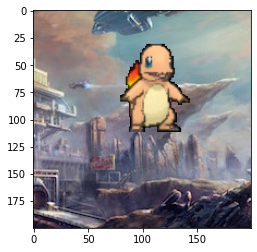

In [ ]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);

print(yy[idx])
print("p(no_object) = ", (yy[:,7] == 0).sum()/n)
print("p(ch pokemon) = ", (yy[:,4] == 0).sum()/n)
print("p(bb pokemon) = ", (yy[:,5] == 0).sum()/n)
print("p(sq pokemon) = ", (yy[:,6] == 0).sum()/n)

In [ ]:
model = make_model_multiclass()
model.fit_generator(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


50/50 [==============================] - 38s 726ms/step - loss: 1.5246
Epoch 2/5
50/50 [==============================] - 36s 724ms/step - loss: 1.2973
Epoch 3/5
50/50 [==============================] - 36s 724ms/step - loss: 1.2234
Epoch 4/5
50/50 [==============================] - 36s 725ms/step - loss: 1.1789
Epoch 5/5
50/50 [==============================] - 36s 717ms/step - loss: 1.0250


In [ ]:
def pokemon_predictions_multiclass():

  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h + POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()

  appear = (np.random.random() < 0.75)

  if appear:
    # which pokemon? 
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]

    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True
    ).astype(np.uint8)

    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # generate random image coordinates
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # placing pokemon into the background
    mask = (obj[:,:,3] == 0) 
    bg_slice = x[row0:row1, col0:col1, :] 
    bg_slice = np.expand_dims(mask, -1) * bg_slice 
    bg_slice += obj[:,:,:3] 
    x[row0:row1, col0:col1, :] = bg_slice 
    print("true", row0, col0, row1, col1)

  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  if p[-1] > 0.5:
    # bounding box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred: ", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
      (p[1]*POKE_DIM, p[0]*POKE_DIM),
      p[3]*POKE_DIM, p[2]*POKE_DIM,
      linewidth=1, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
  else:
    print("pred: no pokemon :(")
    print("p = ", p[4])

  plt.show()

true 143 117 186 151
pred:  164 114 213 152 Charmander


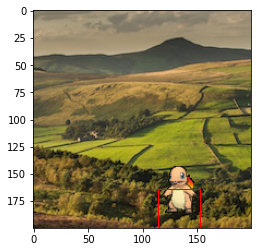

In [ ]:
pokemon_predictions_multiclass()